In [1]:
!pip install transformers

     |████████████████████████████████| 573kB 12.9MB/s 
     |████████████████████████████████| 890kB 41.4MB/s 
     |████████████████████████████████| 3.7MB 39.3MB/s 
     |████████████████████████████████| 1.0MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=259ad86ac6ba41b5a9a7be9c050b39a0c67825adaa174c10cbfd3f86a008bae6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=9db968014a9ebce804a2eb6fd6537159818dc3396342a0fe49665001cad5b30e
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams # check whats this
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict 

from textwrap import wrap

time: 4.75 s


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#l load the Google Play app reviews dataset

!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 73.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 22.8MB/s]
time: 13 s


In [5]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


time: 135 ms


In [6]:
df.shape

(15746, 11)

time: 2.54 ms


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB
time: 20.7 ms


Text(0.5, 0, 'Review Score')

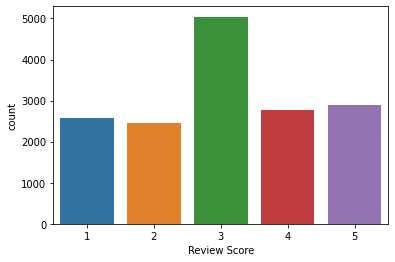

time: 164 ms


In [8]:
sns.countplot(df.score)
plt.xlabel('Review Score')

In [9]:
def score2sentiment(x):
  if x <= 2:
    return 0 #Negetive
  elif x == 3:
    return 1 #Neutral
  else:
    return 2 #Positive

time: 3.26 ms


In [10]:
df['sentiment'] = df.score.apply(score2sentiment)
class_name = ['negative', 'neutral', 'positive']

time: 12.3 ms


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

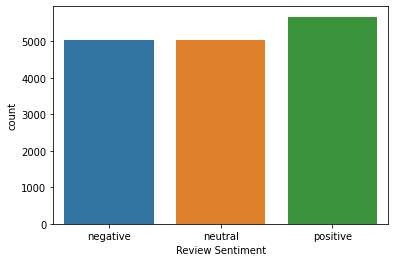

time: 120 ms


In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_name)

quite blanced dataset

## Data Preprocessing

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


time: 2.74 s


In [13]:
sample_text = 'this is Bert classification notebook. And I will use Pytorch'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

time: 2.69 ms


In [14]:
print(
     f'Sentence: {sample_text}\n Tokens: {tokens} \n Token-Id: {token_ids}'
)

Sentence: this is Bert classification notebook. And I will use Pytorch
 Tokens: ['this', 'is', 'Bert', 'classification', 'notebook', '.', 'And', 'I', 'will', 'use', 'P', '##yt', '##or', '##ch'] 
 Token-Id: [1142, 1110, 15035, 5393, 17189, 119, 1262, 146, 1209, 1329, 153, 25669, 1766, 1732]
time: 1.4 ms


Maybe pytorch is not in vocab

In [15]:
# [SEP] - marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

time: 2.48 ms


In [16]:
# [CLS] - to idicate bert we are doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

time: 2.41 ms


In [17]:
# '[PAD]' - for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

time: 2.5 ms


In [18]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    add_special_tokens = True, # cls, pad, etc
    return_token_type_ids=False,
    pad_to_max_length = True,
    return_attention = True,
    return_tensors = 'pt' #return Pytorch tensors 
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

time: 10.2 ms


In [19]:
len(encoding['input_ids'][0])

32

time: 19.6 ms


In [20]:
encoding['input_ids'][0]

tensor([  101,  1142,  1110, 15035,  5393, 17189,   119,  1262,   146,  1209,
         1329,   153, 25669,  1766,  1732,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

time: 12.5 ms


In [21]:
encoding['input_ids'].shape

torch.Size([1, 32])

time: 4.55 ms


In [22]:
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'][0])
encoding['attention_mask'].shape

32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


torch.Size([1, 32])

time: 5.93 ms


In [23]:
# inverse the tokenization to have a look at the special tokens

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'this',
 'is',
 'Bert',
 'classification',
 'notebook',
 '.',
 'And',
 'I',
 'will',
 'use',
 'P',
 '##yt',
 '##or',
 '##ch',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

time: 14 ms


Text(0.5, 0, ' ')

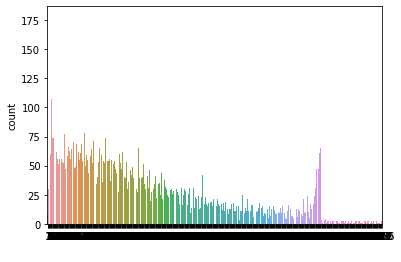

time: 5.9 s


In [24]:
sns.countplot(df.content.str.len())
plt.xlabel(' ')

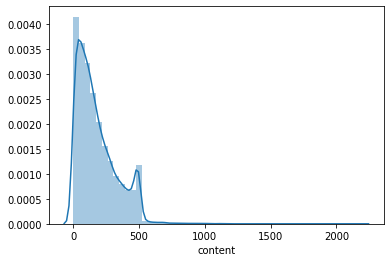

time: 232 ms


In [25]:
sns.distplot(df.content.str.len())

In [26]:
df.content.map(len).max() #¯\_(ツ)_/¯

2176

time: 11.9 ms


Max length of content is somewhere around 115, and bert max_length is 512so everything is good

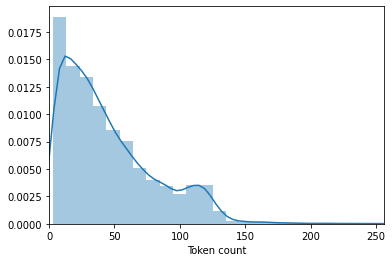

time: 8.16 s


In [27]:
token_lens = []

for text in df.content:
  tokens = tokenizer.encode(text, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

---Most of the reviews seem to contain less than 128 tokens, but we’ll be on the safe side and choose a
maximum length of 160.---

In [28]:
MAX_LENGTH = 160

time: 830 µs


In [87]:
'''class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self. targets = targets
    self.tokenizer = tokenizer
    self.max_leen = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
        'Review-Text':self.review,
        'Input-ids':encoding['input_ids'].flatten(),
        'Attention-mask':encoding['attention_mask'].flatten(),
        'Targets':torch.tensor(target, dtype=torch.long),
    }'''


class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

time: 9 ms


In [88]:
RANDOM_SEED = 7

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

time: 22.9 ms


In [90]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  
  dataset = GPReviewDataset(
      reviews = df.content.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(dataset, batch_size=batch_size, num_workers=4)

time: 1.96 ms


In [91]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE)

time: 4.14 ms


In [92]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

time: 1.93 ms


In [93]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_iterator = iter(train_data_loader)
type(data_iterator)

torch.utils.data.dataloader._MultiProcessingDataLoaderIter

time: 70.8 ms


In [95]:
data = data_iterator.next()
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

time: 17.3 ms


In [101]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 160])
torch.Size([32, 160])
torch.Size([32])
time: 1.47 ms


---

In [96]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


time: 46.9 s


In [97]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])

last_hidden_state.shape

torch.Size([1, 32, 768])

time: 311 ms


In [98]:
bert_model.config.hidden_size

768

time: 3.77 ms


In [99]:
bert_model.config

BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "bert",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pr

time: 2.64 ms


In [100]:
pooled_output.shape

torch.Size([1, 768])

time: 5.19 ms


In [102]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.drop(pooled_output)
    return self.out(output)

time: 4.43 ms


In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

time: 1.34 ms


In [104]:
model = SentimentClassifier(len(class_name))
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

time: 21.3 s


In [105]:
EPOCHS = 15

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheluder = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

time: 5.82 ms


In [112]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheluder, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for data in data_loader:
    input_ids = data["input_ids"].to(device)
    attention_mask = data["attention_mask"].to(device)
    targets = data["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, pred = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(pred == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

time: 10.8 ms


In [110]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      _, pred = torch.max(output, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(pred == targets)
      losses.append(loss.item())

      return correct_predictions.double() / n_examples, np.mean(losses)

time: 9.06 ms


In [113]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheluder, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, optimizer, device, len(df_val))
  print(f'Val loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/15
------------------------------


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe52b2138d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


RuntimeError: ignored

time: 9min 27s
